# EFE Minimization via Message Passing

This notebook is a reproduction of the insightful [A Message Passing Realization of Expected Free Energy Minimization](https://arxiv.org/abs/2508.02197). The paper reformulates Expected Free Energy minimization as Variational Free Energy minimization with epistemic priors, turning a combinatorial search problem into a tractable inference problem solvable through standard message passing on factor graphs. 

The goal of this notebook is to build intuition for the core implementation ideas from the ground up. We only cover the `stochastic maze` environment here; the paper covers two more worth exploring. Since the code has been mostly rewritten for didactic purposes, it doesn't always follow the [accompanying code repo](https://github.com/biaslab/EFEasVFE) conventions.

In [1]:
using Plots
using Base.Iterators
using LinearCombinations
using StableRNGs
using Distributions
using RxInfer
using Tullio
using LogExpFunctions: softmax, xlogx, xlogy
using LinearAlgebra: normalize!, normalize

import Pipe: @pipe as @p

## The `Stochastic Maze` environment

A `Stochastic Maze` is a gridworld where an agent navigates toward a goal state, impeded by:
- sink states that trap the agent (`sink_states`)
- slippery cells where movement outcomes are uncertain (`stochastic_transitions`)
- cells where the agent's perception is unreliable (`noisy_observations`)

We'll define how each of these work when we construct the transition and observation tensors. For now, let's build a concrete example:

In [2]:
Coord = CartesianIndex{2}

@kwdef struct Grid
    indices                :: CartesianIndices{2}
    goal_state             :: Coord
    sink_states            :: Vector{Coord}
    stochastic_transitions :: Vector{Coord}
    noisy_observations     :: Vector{Coord}
end

example_grid = Grid(
    indices                = CartesianIndices((5, 5)),
    goal_state             = Coord(3,5),
    sink_states            = Coord.([(2,4), (4,4)]),
    stochastic_transitions = Coord.([(3,2), (3,3), (3,4)]),
    noisy_observations     = Coord.([(2,2),(2,3),(2,4),(3,2),(3,3),(3,4),(4,2),(4,3),(4,4),(5,3)])
)

Grid(CartesianIndices((5, 5)), CartesianIndex(3, 5), CartesianIndex{2}[CartesianIndex(2, 4), CartesianIndex(4, 4)], CartesianIndex{2}[CartesianIndex(3, 2), CartesianIndex(3, 3), CartesianIndex(3, 4)], CartesianIndex{2}[CartesianIndex(2, 2), CartesianIndex(2, 3), CartesianIndex(2, 4), CartesianIndex(3, 2), CartesianIndex(3, 3), CartesianIndex(3, 4), CartesianIndex(4, 2), CartesianIndex(4, 3), CartesianIndex(4, 4), CartesianIndex(5, 3)])

Since we define the grid in cartesian coordinates but our transition and observation tensors will require linear indices, here are a few utility functions to convert between the two:

In [3]:
to_linear(grid::Grid,    coord::Coord) :: Int   = LinearIndices(grid.indices)[coord]
to_cartesian(grid::Grid, coord::Int)   :: Coord = grid.indices[coord]

to_cartesian (generic function with 1 method)

Let's draw our example grid: The goal is shown in green, sink states in red, stochastic transition cells as horizontally banded, and noisy observation cells in grey.

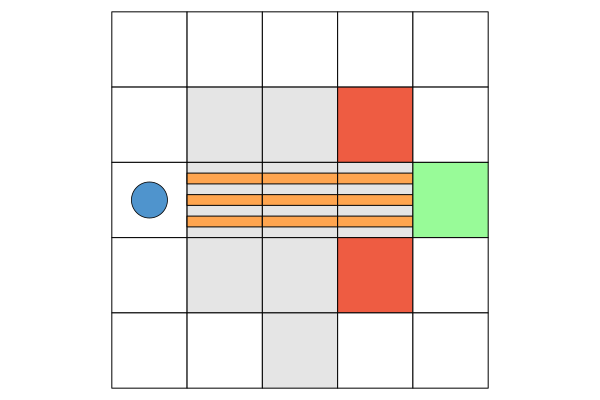

In [4]:
function depict(grid::Grid, player::Coord)
    n_rows, n_cols = size(grid.indices)

    # Helper function to create rectangles
    rectangle(x, y, w, h) = Shape(x .+ [0, w, w, 0], y .+ [0, 0, h, h])
    
    # Create the plot
    p = plot(xlims=(0, n_cols), ylims=(0, n_rows), aspect_ratio=:equal,
             grid=false, showaxis=false, ticks=false, legend=false
    )
    
    for idx in grid.indices
        i, j = Tuple(idx)
        x, y = j - 1, n_rows - i  # Convert to plot coordinates
        
        # Draw square with color based on cell type
        color = idx in grid.sink_states        ? :tomato2   :
                idx == grid.goal_state         ? :palegreen :
                idx in grid.noisy_observations ? :grey90    : :white
        plot!(p, rectangle(x, y, 1, 1), fillcolor=color)
        
        # Draw stochastic transition bands
        if idx in grid.stochastic_transitions
            foreach(k -> plot!(p, rectangle(x, y + k/7, 1, 1/7), fillcolor=:tan1), [1, 3, 5])
        end
        
        # Draw player
        if idx == player
            scatter!(p, [x + 0.5], [y + 0.5], markersize=20, markercolor=:steelblue3)
        end
    end
    return p
end

depict(example_grid, Coord(3,1))

Notice that there is a short path to the goal state, but it passes through the stochastic transition and noisy observation cells, so the agent risks being thrown off the path or losing track of its position, ultimately ending up in a sink state.

One of the main points of the paper is that an agent endowed with the additional epistemic priors we'll discuss later can recognize the risk and choose the longer and more secure path, while simpler agents (for example those endowed with KL-control) tend to take the shorter but riskier route.

## Generation of the tensors

### The state transition tensor

We model the agent's position as a hidden state $x_t$ evolving over time. In a [POMDP](https://en.wikipedia.org/wiki/Partially_observable_Markov_decision_process), the transition dynamics are captured by the conditional distribution:

$$p(x_t \mid x_{t-1}, u_t)$$

We represent this by a tensor of size `(n_states, n_states, n_actions)`, where entry `[i, j, k]` gives the probability of transitioning to state $i$ from state $j$ under action $k$.

The movement rules are straightforward: the agent moves freely in open cells, stays in place when hitting a wall, and in stochastic drift cells there is a 70% chance of being displaced one step up or down regardless of the intended direction.

In [5]:
@enum Direction South=1 North East West

CoordDelta = CartesianIndex{2}

function move(start::Coord, direction::Direction, g::Grid) :: Linear{Coord, Float64}
    translation = Dict(South => CoordDelta(1, 0),
                       North => CoordDelta(-1, 0),
                       East  => CoordDelta(0, 1),
                       West  => CoordDelta(0, -1))
    destination = start + translation[direction]
    destination in g.indices ? Linear(destination => 1.0) : Linear(start => 1.0)
end

function stochastic_drift(start::Coord, g::Grid) :: Linear{Coord, Float64}
    up = move(start, North, g)
    down = move(start, South, g)
    1/2 * (up + down)
end

function movement_tensor(grid :: Grid)
    n_states  = length(grid.indices)
    n_actions = length(instances(Direction))

    movement = zeros((n_states, n_states, n_actions))

    for (source, direction) in product(grid.indices, instances(Direction))
        if source in grid.stochastic_transitions
            destinations = 0.3 * move(source, direction, grid) + 0.7 * stochastic_drift(source, grid)
        elseif source in grid.sink_states
            destinations = Linear(source => 1.0)
        else
            destinations = move(source, direction, grid)
        end

        for (destination, weight) in destinations
            movement[to_linear(grid, destination), to_linear(grid, source), Int(direction)] = weight
        end
    end
    return movement
end

movement_tensor (generic function with 1 method)

A plot of the four slices of the transition tensor, according to the chosen action:

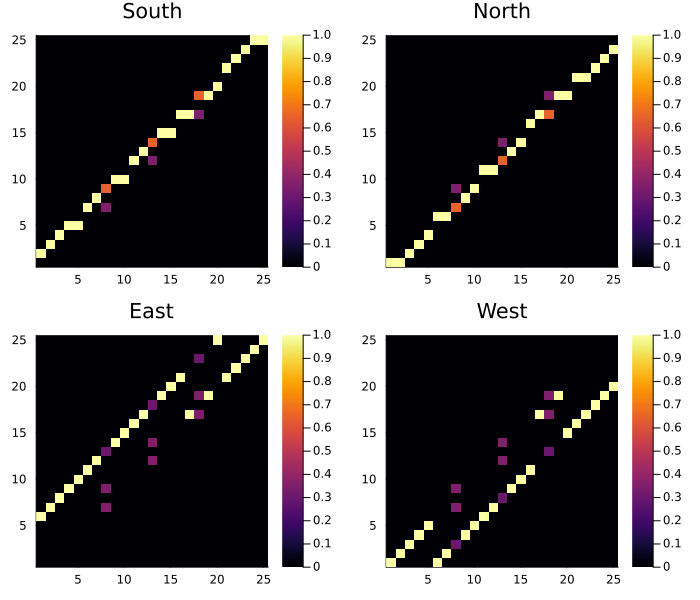

In [6]:
plots = [heatmap(movement_tensor(example_grid)[:,:,i], title="$(instances(Direction)[i])") for i in 1:4]
plot(plots..., layout=(2,2), size=(700, 600))

### The observation tensor

We model observations as a conditional distribution over perceived states given the true hidden state:

$$p(o_t \mid x_t)$$

We represent this as a tensor of size `(n_states, n_states)`, where entry `[i, j]` gives the probability of observing state $i$ when the true state is $j$.

In normal cells the agent perceives its position accurately, while in noisy observation cells it perceives the correct position only 20% of the time, and with 80% probability observes one of the adjacent reachable states (including diagonals).

In [7]:
function adjacent(coord::Coord, grid::Grid) :: Vector{Coord}
    deltas = [Coord(i, j) for i in -1:1 for j in -1:1 if (i, j) != (0, 0)]
    coords = [coord + delta for delta in deltas if coord + delta in grid.indices]
end

function exact(x :: T) :: Linear{T} where {T}
    Linear(x => 1)
end

function linear_combination(xs :: Vector{T}) :: Linear{T} where {T}
    sum(exact.(xs) * (1 / length(xs)))
end

function observation_tensor(grid :: Grid)
    obss = zeros((25, 25))
    for source in grid.indices
        if source in grid.noisy_observations
            observations = 0.2 * exact(source) + 0.8 * linear_combination(adjacent(source, example_grid))
        else
            observations = exact(source)
        end

        for (observation, weight) in observations
            obss[to_linear(grid, observation), to_linear(grid, source)] = weight
        end
    end
    return obss
end

observation_tensor (generic function with 1 method)

A plot of the observation tensor. We can directly observe the uncertainty in noisy observation states.

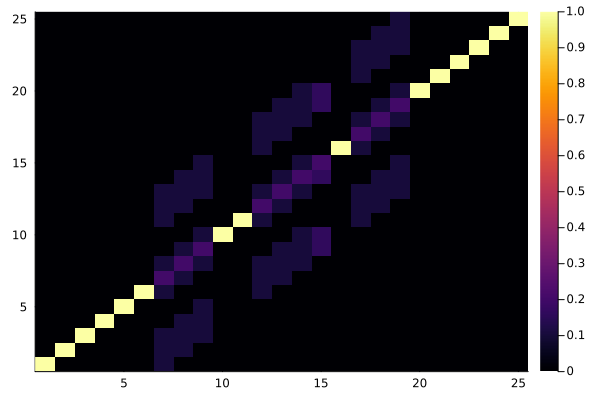

In [8]:
observation_tensor(example_grid) |> heatmap

## Environment step

With the transition and observation tensors defined, we can now implement the environment, which at each timestep samples the next true state from the transition distribution, and a corresponding observation.

In [9]:
function sample_state(rng, grid::Grid, state::Coord, dir::Direction)
    @p state |> to_linear(grid, _) |> movement_tensor(grid)[:,_,Int(dir)] |> Categorical |> rand(rng, _) |> to_cartesian(grid, _)
end

function sample_observation(rng, grid::Grid, agent_pos::Coord)
    @p agent_pos |> to_linear(grid, _) |> observation_tensor(grid)[:,_] |> Categorical |> rand(rng, _) |> to_cartesian(grid, _)
end

function world_step(rng, grid::Grid, player::Coord, direction::Direction)
    next_state  = sample_state(rng, grid, player, direction)
    observation = sample_observation(rng, grid, next_state)
    
    return next_state, observation
end

world_step (generic function with 1 method)

For example here the agent tries to move `East` while starting in $(3,2)$, which is a stochastic transition state. So it ends up going `North` instead, to $(2,2)$. Since the destination is also a noisy observation cell, it perceives itself in $(1,1)$!

In [10]:
world_step(StableRNG(0), example_grid, CartesianIndex(3,2), East)

(CartesianIndex(2, 2), CartesianIndex(1, 1))

## The model

### Model definition

We are ready to construct the model for the agent. The agent has to infer its current state from the most recent observation, and plan over a horizon of length T. While the state inference part is standard, the planning part contains the key insight of the paper: two carefully chosen priors are added to the model, one over actions and the other over states.

The first encodes the expectation that the agent will favor actions that encourage exploration (i.e. maximize the entropy of the transition). In the code, the node responsible for this calculation is thus called `Exploration`. If $q(x_t | x_{t-1}, u_t)$ is the variational transition distribution, and $H_q$ its entropy, we would like a prior for action $u$ proportional to

$$H_q[x_t | x_{t-1}, u_t = u]$$

Note that, by the chain rule of conditional entropy, the quantity is equal to:

$$H_q[x_t, x_{t-1} | u_t = u] - H_q[x_{t-1} | u_t = u]$$

which is why the paper writes:

$$u_t = \text{Cat}(u_t |\sigma(H[q(x_t,x_{t-1}|u_t)] - H[q(x_{t-1}|u_t)]))$$

where the $\sigma$ function (softmax) normalizes the distribution. 


The prior over states encodes the expectation that the agent will tend to occupy states where its observations are reliable (i.e. that minimize the entropy of the observation). The effect is a bias _away_ from ambiguity, and it is why the node responsible for the computation is called `Ambiguity`. As before, if $q(y_t | x_t)$ is the variational observation distribution, and $H_q$ its entropy, we would like a prior for state $x$ proportional to:

$$- H_q[y_t | x_t = x]$$

which the paper writes as:

$$x_t = \text{Cat}(x_t | \sigma(-H[q(y_t|x_t)]))$$

In [11]:
@model function efe_stochastic_maze_agent(A, B, p_s_0, y_current, u_prev, T, n_states, n_actions, goal)
    # Prior initialization
    s_0 ~ p_s_0

    # State inference (filtering)
    s_current ~ DiscreteTransition(s_0, B, u_prev)
    y_current ~ DiscreteTransition(s_current, A)

    # Planning (Active Inference)
    s_prev = s_current
    for t in 1:T
        state_meta = JointMarginalMeta(Contingency(ones(size(B))))
        u[t] ~ Exploration(y_current)              where {meta=state_meta}
        s[t] ~ DiscreteTransition(s_prev, B, u[t]) where {meta=state_meta}
        
        observation_meta = JointMarginalMeta(Contingency(ones(size(A))))
        s[t]        ~ Ambiguity(y_current)         where {meta=observation_meta}
        y_future[t] ~ DiscreteTransition(s[t], A)  where {meta=observation_meta}
        
        y_future[t] ~ Categorical(fill(1 / n_states, n_states))
        s_prev = s[t]
    end
    s[end] ~ goal
end

The figure below shows the factor graph for the state inference part and the first planning step (the planning structure repeats for each subsequent step):
![A graph of the model](graph.jpeg)

Two aspects of this implementation deserve clarification.

Firstly, we know that, to compute the priors, the `Exploration` and `Ambiguity` nodes need to know the joint distribution in the respective `DiscreteTransition` nodes. But that transfer of information is not an edge in the factor graph (edges are for variables shared between factors). So instead stateful back-channels, in the form of the `meta` arguments, are used. This is marked in red in the diagram.

Secondly, the `Exploration` and `Ambiguity` nodes seem to be taking `y_current` as input, which they don't need.
That is needed because by default, RxInfer only computes the value of a node if it has at least one reactive input. Since the `Exploration` and `Ambiguity` nodes have no natural inputs in the graph, they would never be triggered. To work around this, the authors introduced an artificial dependency on `y_current`, marked in blue in the diagram.

Both workarounds are known limitations of the current RxInfer implementation.

### Stateful container containing the joint categorical

A `JointMarginalMeta` is a mutable container, that we use it to store a `Contingency`, which is a joint categorical over multiple discrete variables (defined in RxInfer).

In [12]:
mutable struct JointMarginalMeta{C}
    joint_marginal::C
end

function set_marginal!(jmm::JointMarginalMeta{C}, marginal::C) where {C}
    jmm.joint_marginal = marginal
    return jmm
end

set_marginal! (generic function with 1 method)

### Additional @marginalrules for DiscreteTransitions

Now we'll implement the mechanism with which the `DiscreteTransition` nodes store the joint marginal information in the `JointMarginalMeta`. 

This `@marginalrule` is for a joint marginal over two variables (as in the observation tensor case). The rule fires when the meta parameter is a `JointMarginalMeta` and uses the rule that's already in the [ReactiveMP.jl implementation](https://github.com/ReactiveBayes/ReactiveMP.jl/blob/8b3a7d0d66d86a886b3b8a6e16e3bd3cdaca1f8e/src/rules/discrete_transition/marginals.jl).

In [13]:
RxInfer.ReactiveMP.sdtype(any::RxInfer.ReactiveMP.StandaloneDistributionNode) = ReactiveMP.Stochastic()

@marginalrule DiscreteTransition(:out_in) (m_out::Categorical,
                                           m_in::Categorical,
                                           q_a::PointMass{<:AbstractArray{T,2}},
                                           meta::JointMarginalMeta) where {T} = begin
    marginal = @call_marginalrule DiscreteTransition(:out_in) (m_out=m_out, m_in=m_in, q_a=q_a, meta=nothing)
    set_marginal!(meta, marginal)
    return marginal
end

For a joint marginal over three variables (as in the transition tensor case), we define two `@marginalrule` implementations: the one that does the actual computation, which is not present in `ReactiveMP`, and the one that stores the result in the `JointMarginalMeta`.

In [14]:
@marginalrule DiscreteTransition(:out_in_T1) (m_out::Categorical,
                                              m_in::Categorical,
                                              m_T1::Categorical,
                                              q_a::PointMass{<:AbstractArray{T,3}},
                                              meta::Any) where {T} = begin
    @tullio result[a, b, c] := q_a.point[a, b, c] * probvec(m_out)[a] * probvec(m_in)[b] * probvec(m_T1)[c]
    normalize!(result, 1)
    return Contingency(result, Val(false))
end

@marginalrule DiscreteTransition(:out_in_T1) (m_out::Categorical,
                                              m_in::Categorical,
                                              m_T1::Categorical,
                                              q_a::PointMass{<:AbstractArray{T,3}},
                                              meta::JointMarginalMeta) where {T} = begin
    marginal = @call_marginalrule DiscreteTransition(:out_in_T1) (m_out=m_out, m_in=m_in, m_T1=m_T1, q_a=q_a, meta=nothing)
    set_marginal!(meta, marginal)
    return marginal
end

### Exploration and Ambiguity nodes

We now implement the `Exploration` node. We have to compute:

$$H_q[x_t | x_{t-1}, u_t = u]$$

Recall that conditional entropy is defined as:

$$H_p[A|B] = - \sum_{a, b} p(a, b) \log p(a|b)$$

In [15]:
struct Exploration end

@node Exploration Stochastic [out, in]

function conditional_entropy(x)
    h = sum(x, dims=1)
    @tullio res := - (xlogx(x[a,b]) - xlogy(x[a,b], h[b]))
end

@rule Exploration(:out, Marginalisation) (q_in::Any, meta::JointMarginalMeta,) = begin
    slices = @p meta.joint_marginal |> components |> eachslice(_, dims=3) |> normalize.(_, 1)
    entropies = conditional_entropy.(slices)
    return Categorical(softmax(entropies))
end

For the `Ambiguity` node, we have to compute:

$$- H_q[y_t | x_t = x]$$

In [16]:
struct Ambiguity end

@node Ambiguity Stochastic [out, in];

@rule Ambiguity(:out, Marginalisation) (q_in::Any, meta::JointMarginalMeta,) = begin
    slices = @p meta.joint_marginal |> components |> eachslice(_, dims=2) |> normalize.(_, 1)
    entropies = entropy.(slices)
    return Categorical(softmax(-entropies))
end

## Agent step

We can now create a function that advances the agent by one timestep, instantiating the model, running inference, extracting the first planned action and the updated state belief from the posterior distributions.

In [17]:
function model_step(; grid::Grid, observation::Coord, current_belief, time_remaining::Int, previous_action::Union{Direction, Nothing})
    n_states  = length(grid.indices)
    n_actions = length(instances(Direction))

    onehot(x::Int, n::Int) = Int.(1:n .== x)
    goal_ohe               = @p grid.goal_state |> to_linear(grid, _) |> onehot(_, n_states) |> Categorical
    previous_action_ohe    = isnothing(previous_action) ? [0, 0, 0, 0] : (@p previous_action |> Int |> onehot(_, n_actions))
    observation_ohe        = @p observation |> to_linear(grid, _) |> onehot(_, n_states)

    # Run inference
    result = infer(;
        model = efe_stochastic_maze_agent(
                    A = observation_tensor(grid),
                    B = movement_tensor(grid),
                    p_s_0 = current_belief,
                    T = time_remaining,
                    n_states = n_states,
                    n_actions = n_actions,
                    goal = goal_ohe),
        data=(
            y_current = observation_ohe,
            u_prev = previous_action_ohe
        ),
        initialization = (@initialization begin (s) = vague(Categorical, n_states) end),
        options        = (force_marginal_computation=true,),
        iterations     = 10,
    )

    get_last_iteration = last
    get_first_action   = first
    next_action = @p result.posteriors[:u]         |> get_last_iteration |> get_first_action |> mode |> Direction
    new_belief  = @p result.posteriors[:s_current] |> get_last_iteration

    return next_action, new_belief
end

model_step (generic function with 1 method)

## Running the simulation

Finally, we can run the whole simulation. We initialize four quantities: the agent's true position, its belief over the hidden state, the action it will take, and the observation returned by the environment, updating them at each iteration.
At each timestep, we run one agent inference and one environment simulation, until the agent reaches the goal state or the time horizon is exhausted.

In [18]:
function run_stochastic_maze_simulation(; seed, grid, initial_agent_pos)
    rng = StableRNG(seed)
    time_horizon = 11
    n_states = length(grid.indices)

    agent_pos    = initial_agent_pos
    agent_belief = Categorical(fill(1.0 / n_states, n_states))
    next_action  = nothing
    observation  = sample_observation(rng, grid, initial_agent_pos)

    episode_data = Dict(
        "actions"      => Direction[],
        "states"       => Coord[],
        "observations" => Coord[],
        "seed"         => seed
    )
    push!(episode_data["states"], initial_agent_pos)
    push!(episode_data["observations"], observation)

    for t in time_horizon:-1:1
        # The agent decides on an action
        next_action, agent_belief = model_step(
            grid = grid,
            observation = observation,
            current_belief = agent_belief,
            time_remaining = t,
            previous_action = next_action
        )

        # The world reacts
        agent_pos, observation = world_step(rng, grid, agent_pos, next_action)

        push!(episode_data["actions"], next_action)
        push!(episode_data["states"], agent_pos)
        push!(episode_data["observations"], observation)

        if agent_pos == grid.goal_state break end
    end
    episode_data["final_state"] = agent_pos
    episode_data["seed"] = seed
    return episode_data
end

episode_data = run_stochastic_maze_simulation(seed=123, grid=example_grid, initial_agent_pos=Coord(3,1))

Dict{String, Any} with 5 entries:
  "observations" => CartesianIndex{2}[CartesianIndex(3, 1), CartesianIndex(2, 1…
  "actions"      => Direction[North, North, East, East, East, East, South, Sout…
  "seed"         => 123
  "states"       => CartesianIndex{2}[CartesianIndex(3, 1), CartesianIndex(2, 1…
  "final_state"  => CartesianIndex(3, 5)

Let's create an animation to visualize the agent's trajectory. Modify the grid definition or the agent's starting position to experiment with different scenarios. Keep in mind that planning has a fixed time horizon, and you might need to increase it to allow the agent to reach the goal safely.

In [20]:
animation = @animate for agent_pos in episode_data["states"]
    depict(example_grid, agent_pos)
end

gif(animation, "simulation.gif", fps=4, show_msg = false);

![](simulation.gif)